## From Raw SASE → 220-DBM → 40 eV Spectral Filter


In [41]:
import numpy as np
import matplotlib.pyplot as plt

from tools import Ocelot_SASE_seed_220_dbm_pstxy
from o_globals import h_eV_s, speed_of_light
from Constants import *

# reduced Planck constant [eV·s]
hbar = h_eV_s / (2 * np.pi)

# central photon energy and bandwidth specs
E0     = 8048.0        # eV
fwhm_E =   33.0        # eV

# conversions
sigma_E    = fwhm_E / (2 * np.sqrt(2 * np.log(2)))
rho        = sigma_E / E0
X_bandwidth = 2 * rho
X_lambdaKalpha1N = 2 * np.pi * speed_of_light / E0

In [42]:
class SimParams: pass
X = SimParams()

# spectral / FEL params
X.seed_FEL_bandwidth = X_bandwidth
X.lambdaKalpha1N     = X_lambdaKalpha1N    
X.hwKalpha1N         = E0                  # eV
X.hbar               = hbar                # eV·s
X.Gamma_sp_fsm1N     = 1.0                 # arbitrary units
X.E_seed_uJ          = 1.0                 # seed pulse energy [μJ]

# desired pulse shape (FWHMs in nm or fs)
X.config = {
    'seed_width_FWHM_x'    : 100.0,   # nm
    'seed_width_FWHM_y'    : 100.0,   # nm
    'seed_duration_FWHM_t' : 50.0,    # fs
}

# grid sizes
X.xgrid, X.ygrid, X.tgrid = 64, 64, 512
X.xmax,  X.ymax,  X.tmax   = 100.0, 100.0, 200.0  # nm, nm, fs

# step‐sizes
X.dx = (2 * X.xmax) / X.xgrid     # nm
X.dy = (2 * X.ymax) / X.ygrid     # nm
X.dt =       X.tmax  / X.tgrid    # fs

# **the missing time axis** (so that Roh(X) can do `t = X.t - X.tmax/2`)
X.t = np.linspace(0, X.tmax, X.tgrid)  # fs
X.seed_delay = 0  # fs

# (optional) build explicit z↔kz arrays to replace any future scale_kz calls
grid_z  = X.t                                       # fs
grid_kz = np.fft.fftshift(np.fft.fftfreq(X.tgrid, d=X.dt)) * 2*np.pi  # (rad/fs) 

In [43]:
Ω = Ocelot_SASE_seed_220_dbm_pstxy(X)
# Ω has shape (2,2,t,x,y); the linear‐y component is Ω[0,1]
field = Ω[0,1]   # complex array shape (t, x, y)

print(Ω)

: dgrid[2]/dfl.Nz() = dz = 1.1710642890625001e-07, which is smaller than xlamds = 0.00023405213311491715. zsep set to 1
"scale_kz" will be deprecated, use "grid_z and grid_kz" instead


number of seed photons = 7.8e+08
[[[[[ 0. +0.j  0. +0.j  0. +0.j ...  0. +0.j  0. +0.j  0. +0.j]
    [ 0. +0.j  0. +0.j  0. +0.j ...  0. +0.j  0. +0.j  0. +0.j]
    [ 0. +0.j  0. +0.j  0. +0.j ...  0. +0.j  0. +0.j  0. +0.j]
    ...
    [ 0. +0.j  0. +0.j  0. +0.j ...  0. +0.j  0. +0.j  0. +0.j]
    [ 0. +0.j  0. +0.j  0. +0.j ...  0. +0.j  0. +0.j  0. +0.j]
    [ 0. +0.j  0. +0.j  0. +0.j ...  0. +0.j  0. +0.j  0. +0.j]]

   [[ 0. +0.j  0. +0.j  0. +0.j ...  0. +0.j  0. +0.j  0. +0.j]
    [ 0. +0.j  0. +0.j  0. +0.j ...  0. +0.j  0. +0.j  0. +0.j]
    [ 0. +0.j  0. +0.j  0. +0.j ...  0. +0.j  0. +0.j  0. +0.j]
    ...
    [ 0. +0.j  0. +0.j  0. +0.j ...  0. +0.j  0. +0.j  0. +0.j]
    [ 0. +0.j  0. +0.j  0. +0.j ...  0. +0.j  0. +0.j  0. +0.j]
    [ 0. +0.j  0. +0.j  0. +0.j ...  0. +0.j  0. +0.j  0. +0.j]]

   [[ 0. +0.j  0. +0.j  0. +0.j ...  0. +0.j  0. +0.j  0. +0.j]
    [ 0. +0.j  0. +0.j  0. +0.j ...  0. +0.j  0. +0.j  0. +0.j]
    [ 0. +0.j  0. +0.j  0. +0.j ...  0. +0.j  0. +0

/Users/yehaoran/Desktop/DESY_2025/X-ray_Polarisation_Control/tools.py:357: RuntimeWarning: invalid value encountered in divide
  return np.heaviside(t, 1) * (sp_func.jv(1, t/Tg) / (1j*t)) * np.exp(exparg)
/Users/yehaoran/Desktop/DESY_2025/X-ray_Polarisation_Control/tools.py:357: RuntimeWarning: overflow encountered in exp
  return np.heaviside(t, 1) * (sp_func.jv(1, t/Tg) / (1j*t)) * np.exp(exparg)
/Users/yehaoran/Desktop/DESY_2025/X-ray_Polarisation_Control/tools.py:427: RuntimeWarning: invalid value encountered in divide
  field_txy = field_txy / norm


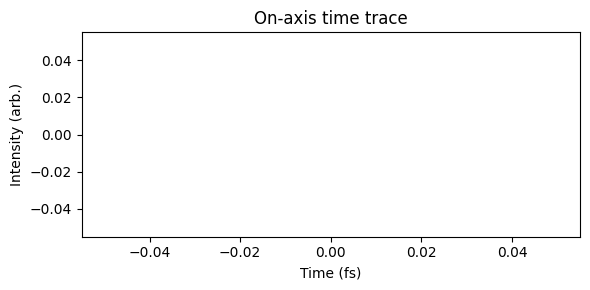

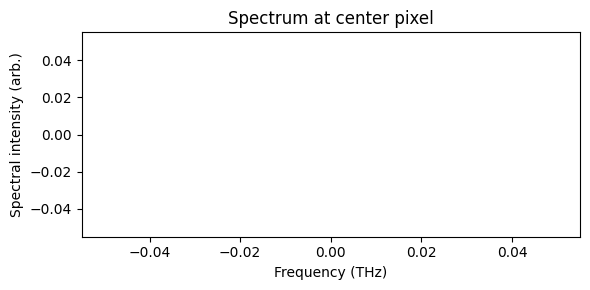

In [ ]:
ix0, iy0 = X.xgrid//2, X.ygrid//2
t    = np.linspace(0, X.tmax, X.tgrid)               # fs
I_t  = np.abs(field[:, ix0, iy0])**2                 # arb. units

# time‐domain
plt.figure(figsize=(6,3))
plt.plot(t, I_t, '-k')
plt.xlabel('Time (fs)')
plt.ylabel('Intensity (arb.)')
plt.title('On-axis time trace')
plt.tight_layout()

# freq‐domain (THz)
freq = np.fft.fftshift(np.fft.fftfreq(X.tgrid, d=X.dt*1e-15)) * 1e-12
spec = np.abs(np.fft.fftshift(np.fft.fft(field[:,ix0,iy0])))**2

plt.figure(figsize=(6,3))
plt.plot(freq, spec, '-b')
plt.xlabel('Frequency (THz)')
plt.ylabel('Spectral intensity (arb.)')
plt.title('Spectrum at center pixel')
plt.tight_layout()
plt.show()

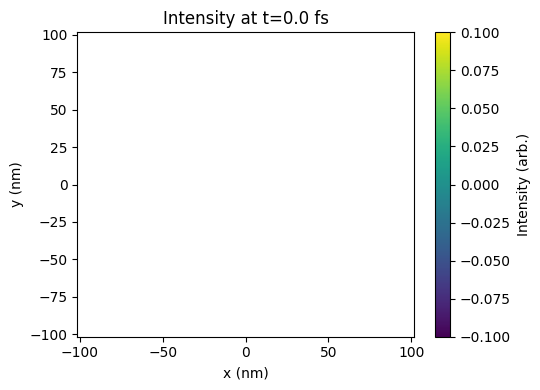

In [34]:
t_peak = np.argmax(I_t)
I_xy   = np.abs(field[t_peak])**2

x = np.linspace(-X.xmax, X.xmax, X.xgrid)
y = np.linspace(-X.ymax, X.ymax, X.ygrid)
Xg, Yg = np.meshgrid(x, y, indexing='ij')

plt.figure(figsize=(5.5,4))
plt.pcolormesh(Xg, Yg, I_xy, shading='auto')
plt.xlabel('x (nm)')
plt.ylabel('y (nm)')
plt.title(f'Intensity at t={t[t_peak]:.1f} fs')
plt.colorbar(label='Intensity (arb.)')
plt.tight_layout()
plt.show()